# Flow-based communities

This notebook reproduces plots that appear in Fig 8 of the paper:
- Gilson M, Zamora-López G, Pallarés V, Adhikari MH, Senden M, Tauste Campo A, Mantini D, Corbetta M, Deco G, Insabato A (submitted) "Model-based whole-brain effective connectivity to study distributed cognition in health and disease", bioRxiv; https://doi.org/10.1101/531830.

The goal is to detect communities of brain regions (or ROIs) that have strong interactions between them, interactions being quantified by the flow as calculated in the *Flow* notebook. Note that the flow is calculated manually here, for didactic purpose.

See also for an application to resting-state fMRI data of the related network analysis using dynamic communicability:
- Gilson M, Kouvaris NE, Deco G, Mangin J-F, Poupon C, Lefranc S, Rivière D, Zamora-López G (2019) "Network analysis of whole-brain fMRI dynamics: A new framework based on dynamic communicability", Neuroimage 201, 116007  https://doi.org/10.1016/j.neuroimage.2019.116007.

In [1]:
# toggle to True to create directory and store results there
save_outputs = False
if save_outputs:
    import os
    res_dir = 'flow/'
    if not os.path.exists(res_dir):
        os.mkdir(res_dir)

In [14]:
# Import dependencies
from __future__ import division
import numpy as np
import scipy.linalg as spl
import scipy.stats as stt

import matplotlib.pyplot as plt

In [4]:
# Set data parameters
param_dir = 'model_param_movie/'
n_sub = 22 # number of subjects
n_run = 5  # number of sessions per subject (2 rest + 3 movie)
N = 66     # number of ROIs

# Load the ROI labels
ROI_labels = np.load('ROI_labels.npy')

# Load the Jacobian and the noise covariance. Created in notebook 'MOU_EC_Estimation.ipybn'
J = np.load(param_dir + 'J_mod.npy')
Sigma = np.load(param_dir + 'Sigma_mod.npy')

# create binary masks
mask_diag = np.eye(N,dtype=np.bool)
mask_offdiag = np.logical_not(mask_diag)

The following function implements the greedy algorithm used by Newman to iteratively aggregate ROIs according to their flow interactions. This corresponds to a quality function *Q* that should be maximized and each step calculates all possible changes of *Q* when pairing 2 groups. The algorithm is initialized with singletons, each ROI being assigned to a group of 1 element. When *Q* cannot be increased, the algorithm stops.

In [5]:
# Community detection function (Newman greedy aggregation)
def calc_part(inter_mat):
   # initial partition with all nodes disconnected (each in a singleton)
    part_tmp = []
    for i in range(N):
        part_tmp += [[i]]
    stop = False
    while not stop:
        n = len(part_tmp) # lenght of current partition (number of groups)
        delta_Q = np.zeros([n,n]) # matrix of Q update when merging a pair of groups
        # check change in Q for all possible merging of 2 groups
        for ii in range(n):
            for jj in range(n):
                if ii!=jj:
                    for i in part_tmp[ii]:
                        for j in part_tmp[jj]:
                            delta_Q[ii,jj] += inter_mat[i,j] + inter_mat[j,i] # sum of interactions between 2 groups
                else:
                    # only calculate for distinct groups, here set to a large negative value
                    delta_Q[ii,jj] = -1e50
        # check if Q can be increased; if not, stop
        if delta_Q.max()>0:
            # get indices of groups for maximum change of Q
            ii_max = int(np.argmax(delta_Q)/n)
            jj_max = np.argmax(delta_Q) - ii_max*n
            # create new partition with merging of ii_max and jj_max
            new_part_tmp = []
            for ii in range(n):
                if ii!=ii_max and ii!=jj_max:
                    new_part_tmp += [part_tmp[ii]]
                elif ii==ii_max:
                    new_part_tmp += [part_tmp[ii_max]+part_tmp[jj_max]]
            part_tmp = new_part_tmp
        else:
            stop = True
    return part_tmp # return partition as list of integer lists

Now we use the function to detect communities for each subject at 3 integration times: early (t = 1 TR), when the network effect is strong (t = 5 TR) and late (t = 20 TR).

In [10]:
# diagonal of Jacobian
J0 = np.array(J)
J0[:,:,mask_offdiag] = 0

# integration times for community detection
vT = np.array([1,5,20],dtype=np.int)
nT = vT.size

# Newman-style expected C with directed conn
C_null = np.zeros(J.shape)
for i_sub in range(n_sub): # in * out / total
    for i_run in range(n_run): # in * out / total
        C = np.copy(J[i_sub,i_run,:,:])
        C[mask_diag] = 0
        C_null[i_sub,i_run,:,:] = np.outer(C.sum(1),C.sum(0))
        C_null[i_sub,i_run,mask_diag] = 0
        C_null[i_sub,i_run,:,:] *= C.sum() / C_null[i_sub,i_run,:,:].sum()

summary_community = np.zeros([n_sub,n_run,nT,N,N]) # community analysis from similarity of communicability
for i_sub in range(n_sub):
    for i_run in range(n_run):
        print('sub/run', i_sub, i_run)
        renorm_factor = -np.sum(1./J0[i_sub,i_run,:,:].diagonal())
        for iT in range(nT):
            # difference between communicability and null version
            flow_diff_null_tmp = (spl.expm(J[i_sub,i_run,:,:]*vT[iT]) - spl.expm((J0[i_sub,i_run,:,:]+C_null[i_sub,i_run,:,:])*vT[iT])) / renorm_factor
            flow_diff_null_tmp = np.dot(np.sqrt(Sigma[i_sub,i_run,:,:]),flow_diff_null_tmp)

            # calculate communities
            part_tmp = calc_part(flow_diff_null_tmp)
            print('t =', vT[iT], ':', len(part_tmp)) # print number of groups

            # matrices of coparticipation values: add 1 if the 2 groups are in the same community for each subject/session
            for ip in range(len(part_tmp)):
                for i in part_tmp[ip]:
                    for j in part_tmp[ip]:
                        if i_run<2:
                            summary_community[i_sub,0,iT,i,j] += 1
                        else:
                            summary_community[i_sub,1,iT,i,j] += 1
summary_community[:,0,:,:,:] /= 2.
summary_community[:,1,:,:,:] /= 3.

if save_outputs:
    np.save(res_dir+'summary_community.npy',summary_community)

sub/run 0 0
8
8
13
sub/run 0 1
8
6
10
sub/run 0 2
8
6
13
sub/run 0 3
8
7
13
sub/run 0 4
8
8
9
sub/run 1 0
6
6
9
sub/run 1 1
7
7
8
sub/run 1 2
5
6
6
sub/run 1 3
7
6
9
sub/run 1 4
7
5
11
sub/run 2 0
7
6
9
sub/run 2 1
6
6
8
sub/run 2 2
6
6
9
sub/run 2 3
8
7
8
sub/run 2 4
7
7
10
sub/run 3 0
6
5
7
sub/run 3 1
7
6
8
sub/run 3 2
7
7
8
sub/run 3 3
6
6
11
sub/run 3 4
7
5
14
sub/run 4 0
6
5
9
sub/run 4 1
7
6
10
sub/run 4 2
8
7
9
sub/run 4 3
6
5
9
sub/run 4 4
7
6
12
sub/run 5 0
5
5
11
sub/run 5 1
8
7
14
sub/run 5 2
6
7
14
sub/run 5 3
7
5
21
sub/run 5 4
6
6
16
sub/run 6 0
6
5
15
sub/run 6 1
7
6
9
sub/run 6 2
7
8
7
sub/run 6 3
7
5
9
sub/run 6 4
7
6
11
sub/run 7 0
6
5
13
sub/run 7 1
6
5
13
sub/run 7 2
7
5
14
sub/run 7 3
8
7
12
sub/run 7 4
7
5
13
sub/run 8 0
7
5
11
sub/run 8 1
7
5
11
sub/run 8 2
8
7
9
sub/run 8 3
6
8
8
sub/run 8 4
9
9
9
sub/run 9 0
7
6
10
sub/run 9 1
7
6
6
sub/run 9 2
7
5
9
sub/run 9 3
7
8
9
sub/run 9 4
8
8
6
sub/run 10 0
6
6
7
sub/run 10 1
7
5
9
sub/run 10 2
6
6
11
sub/run 10 3
8
7


Now we reorder the ROIs by grouping them according to the community structure at rest averaged over all subjects.

In [25]:
# reorder ROIs according to rest community for early integration time (assess stable communities over all rest sessions)
stab_community_rest = summary_community[:,:2,0,:,:].mean(axis=(0,1))
stab_community_rest[mask_diag] = 0
stab_community_rest_null = np.outer(stab_community_rest.sum(1),stab_community_rest.sum(0))
stab_community_rest_null[mask_diag] = 0
stab_community_rest_null *= stab_community_rest.sum() / stab_community_rest_null.sum()

part_rest = calc_part(stab_community_rest - stab_community_rest_null)

print('number of groups:', len(part_rest))
for ii in range(len(part_rest)):
    print('group', ii, 'with', len(part_rest[ii]), 'ROIs')
    for i in part_rest[ii]:
        print(ROI_labels[i],)
    print()
# reorganize ROI according to partition
part_ind = np.array(part_rest[0]+part_rest[2]+part_rest[1]+part_rest[3],dtype=int)

if save_outputs:
    np.save(res_dir+'part_ind.npy',part_ind)

number of groups: 4
group 0 with 18 ROIs
 rCAC
 lCAC
  rMT
rPARC
lPARC
  lST
  rTT
  lTT
  rST
  lMT
rSMAR
lSMAR
  rTP
  lTP
 rRMF
  rSF
  lSF
 lRMF

group 1 with 16 ROIs
 rCMF
 rCUN
 lCUN
lPSTC
rPSTC
lPREC
rPREC
rBSTS
lBSTS
  rPC
  lPC
 lRAC
 rRAC
lPCUN
rPCUN
 lCMF

group 2 with 20 ROIs
 rENT
 rFUS
rLOCC
rLING
rPCAL
lPCAL
lLING
lLOCC
 lFUS
lPARH
rPARH
  lIT
  rIT
rISTC
lISTC
  lIP
  rIP
  rSP
  lSP
 lENT

group 3 with 12 ROIs
  rFP
  lFP
lPORB
 lLOF
 rLOF
rPORB
lPOPE
lPTRI
rPOPE
rPTRI
 lMOF
 rMOF



Plot the matrices of coparticipation values. the coparticipation values are close to 1 if the two ROIs are in the same community for all subjects of a condition (rest or movie). Otherwise, it is close to 0.

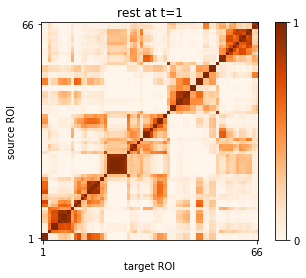

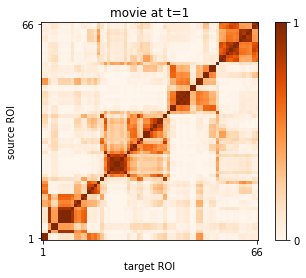

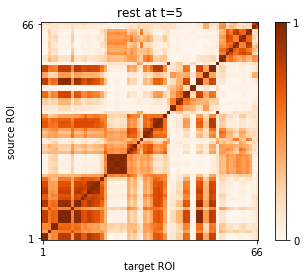

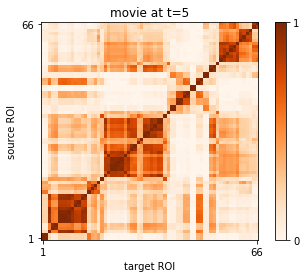

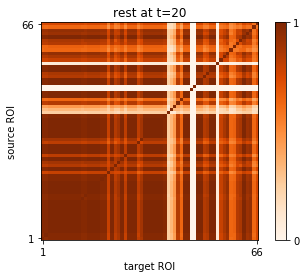

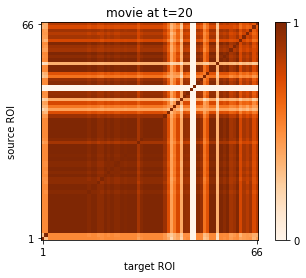

In [22]:
# matrix plots of flow communities with reordered indices
for iT in range(nT):
    plt.figure()
    plt.imshow(summary_community[:,0,iT,:,:].mean(0)[part_ind,:][:,part_ind], origin='lower', vmin=0, vmax=1, cmap='Oranges')
    plt.xticks([0,65],['1','66'])
    plt.yticks([0,65],['1','66'])
    plt.xlabel('target ROI')
    plt.ylabel('source ROI')
    plt.colorbar(ticks=[0,1])
    plt.title('rest at t='+str(vT[iT]))
    if save_outputs:
        plt.savefig(res_dir+'reord_flow_rest_t'+str(iT))

    plt.figure()
    plt.imshow(summary_community[:,1,iT,:,:].mean(0)[part_ind,:][:,part_ind], origin='lower', vmin=0, vmax=1, cmap='Oranges')
    plt.xticks([0,65],['1','66'])
    plt.yticks([0,65],['1','66'])
    plt.xlabel('target ROI')
    plt.ylabel('source ROI')
    plt.colorbar(ticks=[0,1])
    plt.title('movie at t='+str(vT[iT]))
    if save_outputs:
        plt.savefig(res_dir+'reord_flow_movie_t'+str(iT))
    
plt.show()

Check significant changes in community coparticipation values between rest and movie.

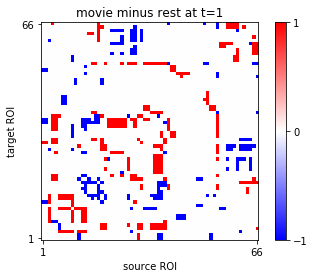

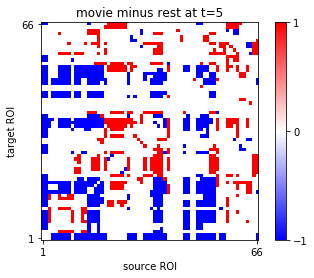

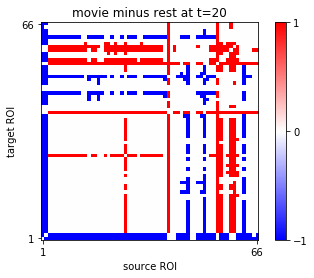

In [21]:
sig_diff_flow = np.zeros([nT,N,N])
for iT in range(nT):
    for i in range(N):
        for j in range(N):
            if not np.array_equiv(summary_community[:,0,iT,i,j],summary_community[:,1,iT,i,j]) \
                and stt.mannwhitneyu(summary_community[:,0,iT,i,j],summary_community[:,1,iT,i,j])[1]<0.01: #0.05/(N*(N-1)):
                sig_diff_flow[iT,i,j] = np.sign(summary_community[:,1,iT,i,j].mean()-summary_community[:,0,iT,i,j].mean())
                
# matrix plots of statistical differences between coparticipation values
for iT in range(nT):
    plt.figure()
    plt.imshow(sig_diff_flow[iT,part_ind,:][:,part_ind], origin='lower', vmin=-1, vmax=1, cmap='bwr')
    plt.xticks([0,65],['1','66'])
    plt.yticks([0,65],['1','66'])
    plt.xlabel('target ROI')
    plt.ylabel('source ROI')
    plt.colorbar(ticks=[-1,0,1])
    plt.title('movie minus rest at t='+str(vT[iT]))
    if save_outputs:
        plt.savefig(res_dir+'sig_chg_community_t'+str(iT)+'.'+graph_format,format=graph_format,transparent=True)
    
plt.show()